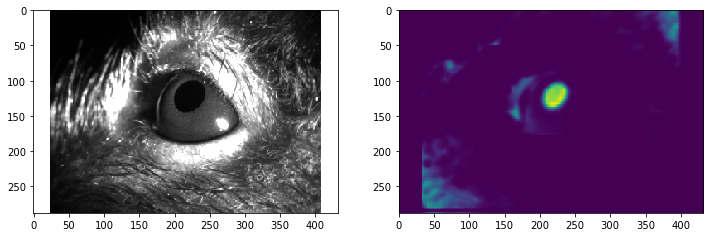

In [8]:
# coding: utf-8

# In[5]:

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib
import matplotlib.pyplot as plt
#get_ipython().magic(u'matplotlib inline')
from sklearn.model_selection import train_test_split


# In[2]:

from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint


# ## Load and resize the images

# In[3]:

#IMAGE_LIB = './human/'
#MASK_LIB = './human/'

IMAGE_LIB = './datasets/pupil/img/'
MASK_LIB = './datasets/pupil/masks/'

IMG_HEIGHT, IMG_WIDTH = 288, 432
SEED=42


# In[4]:

#all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.png']
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-1] == 'g']

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, 0).astype("int16").astype('float32')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    x_data[i] = im

y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(MASK_LIB + name, 0).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im

# In[5]:

# fig, ax = plt.subplots(1,2, figsize = (8,4))
# ax[0].imshow(x_data[0], cmap='gray')
# ax[1].imshow(y_data[0], cmap='gray')
# plt.show()


# In[6]:

x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.5)


# ## Define and train model

# In[7]:

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())


# In[8]:

input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)

l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)

l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)

l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)

l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)

l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)

l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)

l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)

output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)

model = Model(input_layer, output_layer)


# In[9]:

#model.summary()


# In[10]:

def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        rotation_range=10,
        zoom_range=0.1,
        fill_mode='constant',
        cval=0.1).flow(x_train, x_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        rotation_range=10,
        zoom_range=0.1,
        fill_mode='constant',
        cval=0.0).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch


# By using the same RNG seed in both calls to ImageDataGenerator, we should get images and masks that correspond to each other. Let's check this, to be safe.

# In[11]:

# image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
# fix, ax = plt.subplots(8,2, figsize=(8,20))
# for i in range(8):
#     ax[i,0].imshow(image_batch[i,:,:,0])
#     ax[i,1].imshow(mask_batch[i,:,:,0])
# plt.show()


# In[12]:

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef])


# In[13]:

weight_saver = ModelCheckpoint('pupil_weights.h5', monitor='val_dice_coef',
                               save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)


# In[14]:
'''
hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=2, verbose=2,
                           #epochs=2, verbose=2,
                           callbacks = [weight_saver, annealer])
'''
# ## Evaluate

# In[15]:

model.load_weights('pupil_weights.h5')


# In[16]:

# plt.plot(hist.history['loss'], color='b')
# plt.plot(hist.history['val_loss'], color='r')
# plt.show()
# plt.plot(hist.history['dice_coef'], color='b')
# plt.plot(hist.history['val_dice_coef'], color='r')
# plt.show()


# In[17]:

#plt.imshow(model.predict(x_train[0].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')
#plt.show()


# In[18]

y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(x_val[0,:,:,0], cmap='gray')
#ax[1].imshow(y_val[0,:,:,0])
ax[1].imshow(y_hat[0,:,:,0])
plt.show()

'''
y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(x_val[0,:,:,0], cmap='gray')
ax[1].imshow(y_hat[0,:,:,0])
print("Fig 2")
plt.show()
#ax[2].imshow(y_hat[0,:,:,0])
'''

print ""
# A good result, in fact the prediction looks better than the mask on some examples.

# In[19]:
